# Cluster Bacillus Sequences with unknown functions 


In [32]:
#imports 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns 

In [18]:
#read in the sequences embedded with mini bacillus model 
embedding_unk_s =pd.read_csv('/home/grig0076/Protvec/AMSI_Ontology/notebooks/all_bacillus/bacillus_unk_embedded.csv', sep = '\t')
embedding_unk = embedding_unk_s.dropna()
embedding_unk = embedding_unk.sort_values(by=['Unnamed: 0'])
unk_keys = list(embedding_unk['Unnamed: 0'].values)

#standardise the embedding 
scaled_unk = StandardScaler().fit_transform(embedding_unk.drop(['Unnamed: 0'], axis = 1).values)
scaled_unk_df = pd.DataFrame(scaled_unk, index = embedding_unk['Unnamed: 0'])

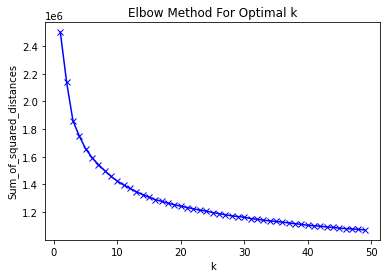

In [22]:
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    #print('K: ' + str(k))
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_unk_df)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
#load in the colour map - from https://personal.sron.nl/~pault/
paired =  ["#88CCEE",
            "#CC6677",
            "#DDCC77",
            "#117733",
            "#332288",
            "#AA4499",
            "#44AA99",
            "#999933",
            "#882255",
            "#661100",
            "#6699CC",
            "#888888"]
color_dict = dict(zip([i for i in range(0,len(paired))],paired))

In [55]:
#set the number of clusters to be displayed 
k = 12

Kmeans_model = KMeans(n_clusters=k, random_state=0)
Kmeans_model.fit(scaled_unk)
Kmeans_labels = Kmeans_model.labels_ 

#get the kmeans centres
Kmeans_centres = Kmeans_model.cluster_centers_

# euclidean distance from each point to each cluster centroid
D = cdist(scaled_unk, Kmeans_centres, 'euclidean')

centroid_list = []
dist_list = [] 

for i in range(len(D)): 
    dist = np.min(D[i])
    cent = np.where(D[i] == D[i].min())[0][0]
    
    #add distance and centroid information 
    dist_list.append(dist)
    centroid_list.append(cent)
    
#assemble into a dataframe 
Kmeans_info = pd.DataFrame({'md5': unk_keys, 'centroid': centroid_list, 'dist': dist_list})

#get the 100 sequences closest to the centroid 
close_md5s = []
close_centroids = []

for i in range(0,k): 
    
    #get a 'sub' dataframe corresponding to the centroid 
    this_centroid = Kmeans_info[Kmeans_info['centroid'] == i].sort_values('dist').reset_index()
    
    #get the top 100 md5 sums 
    this_md5 = this_centroid[0:100]['md5'].values
    
    #add these md5s to list
    for md5 in this_md5: 
        close_md5s.append(md5)
        close_centroids.append(i)
        
        
close_md5_centroid_unk = pd.DataFrame({'md5': close_md5s, 'centroid': close_centroids})
close_md5_centroid_unk = close_md5_centroid_unk.sort_values('md5')

#get the embedding corresponding to these close sequences 
embedding_close = embedding_unk[embedding_unk['Unnamed: 0'].isin(close_md5_centroid_unk['md5'])]
embedding_close_scaled =  StandardScaler().fit_transform(embedding_close.drop(['Unnamed: 0'], axis = 1).values)

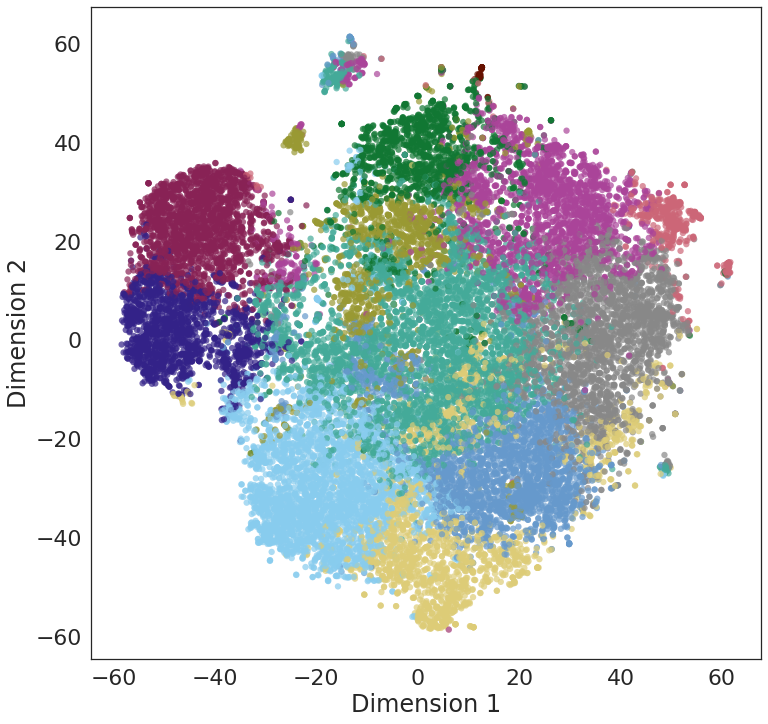

In [60]:
#do the tSNE
tsne = TSNE(perplexity = 30, learning_rate =200)
embedding_tsne = tsne.fit_transform(scaled_unk)

#colour by subclass 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2'])
tsne_df.index = unk_keys
tsne_df['Kmeans'] = centroid_listz
tsne_df['Hue'] = [color_dict.get(i) for i in tsne_df.Kmeans]

plt.figure(figsize=(12,12))
sns.set(style="white", font_scale=2)

sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', data = tsne_df[:len(tsne_df)-12], legend = 'full', s = 40,linewidth=0, alpha = 0.7, c = [color_dict.get(i) for i in tsne_df[:len(tsne_df)-12].Kmeans])#hue = 'Kmeans',palette = paired)
plt.legend([],[], frameon=False)

In [61]:
embedding_unk_centroids = pd.DataFrame(scaled_unk).append(pd.DataFrame(Kmeans_centres))

#do the tSNE
tsne = TSNE(perplexity = 30, learning_rate =200)
embedding_tsne = tsne.fit_transform(embedding_unk_centroids)

#colour by subclass 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2'])


In [58]:
tsne_df.index = unk_keys + [i+1 for i in range(0,k)]
tsne_df['Kmeans'] = centroid_list + [i+1 for i in range(0,k)]
tsne_df['Hue'] = [color_dict.get(i) for i in tsne_df.Kmeans]

/local/grig0076/118942/ipykernel_2375862/1890438846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsne_df_close['Hue'] = [color_dict.get(i) for i in tsne_df_close.Kmeans]


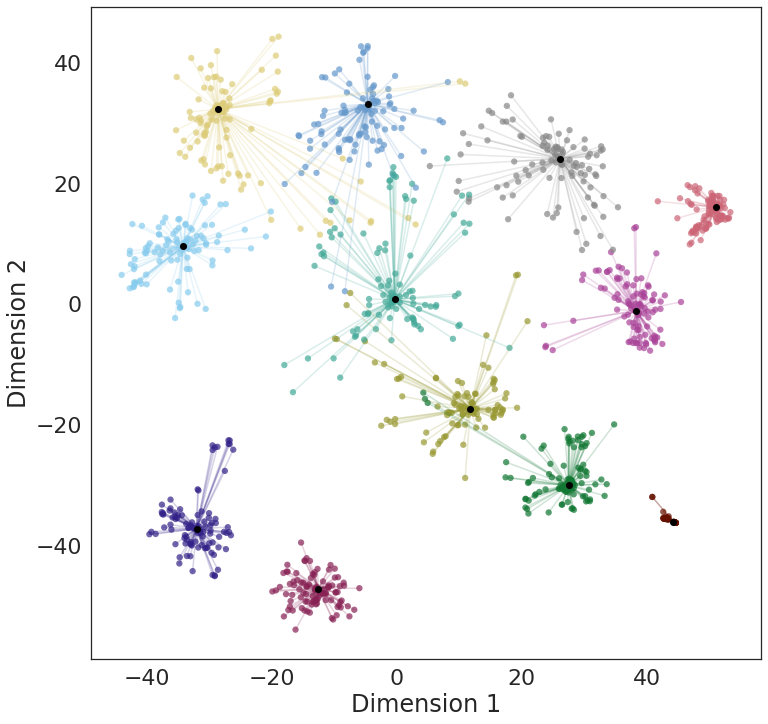

In [59]:
#plot the sequences closest to each centroid
tsne_df_close = tsne_df[tsne_df.index.isin(close_md5_centroid_unk['md5'] )]
tsne_df_centroid = tsne_df.iloc[len(tsne_df) - k:len(tsne_df)]

tsne_df_close['Hue'] = [color_dict.get(i) for i in tsne_df_close.Kmeans]

#tsne_df['Kmeans'] = close_md5_centroid_unk['centroid'].values

plt.figure(figsize=(12,12))
sns.set(style="white", font_scale=2)

centroids = sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', 
                
                data = tsne_df_centroid, legend = 'full', s = 50,linewidth=0,  palette = 'tab20', color = 'black',  zorder = 7)
plt.legend([],[], frameon=False)



sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', data = tsne_df_close, legend = 'full', s = 40,linewidth=0, alpha = 0.7, c =[color_dict.get(i) for i in tsne_df_close.Kmeans] )#hue = 'Kmeans',palette = paired)
plt.legend([],[], frameon=False)


for md5 in tsne_df_close.index: 
    md5_dim1 = tsne_df_close.loc[md5]['Dimension 1']
    md5_dim2 = tsne_df_close.loc[md5]['Dimension 2']
    cluster = tsne_df_close.loc[md5]['Kmeans']+1
    
    #print(cluster)
    cluster_dim1 = tsne_df_centroid[tsne_df_centroid['Kmeans'] == cluster]['Dimension 1'].values[0]
    cluster_dim2 = tsne_df_centroid[tsne_df_centroid['Kmeans'] == cluster]['Dimension 2'].values[0]
    
    x = [md5_dim1, cluster_dim1]
    y = [md5_dim2, cluster_dim2]
    
    #get a color corresponding to the cluster 
    plt.plot(x, y, c=color_dict.get(cluster-1), alpha=0.2)